In [41]:
import pickle

# Data wrangleing
import numpy as np
import pandas as pd

# Vizualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Selecção e validação de modelo
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir na pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modelos
from sklearn.dummy import DummyRegressor # Baseline mais cru possível
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")



- Função para pegar as métricas

In [4]:
def get_metrics (y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred)) # Este erro médio penalisa mais os outlayers
    }
    return dict_metrics

In [5]:
path = "/home/faust/Projetos/DNC/Mes-06/insurence/data/insurance.csv"
df = pd.read_csv(path)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='age', ylabel='charges'>

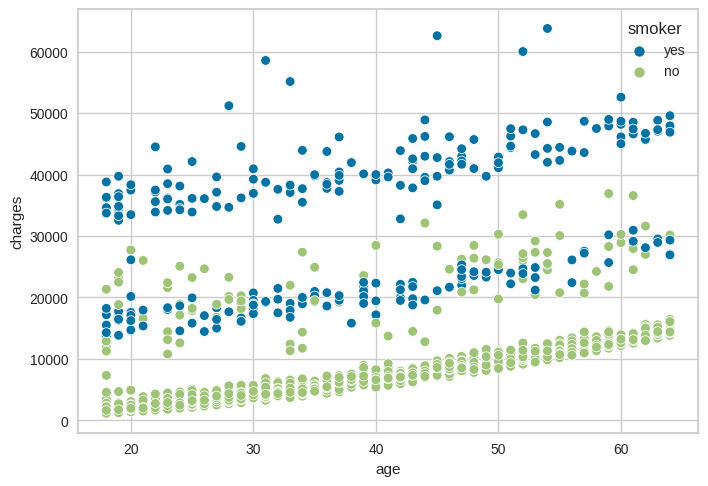

In [8]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

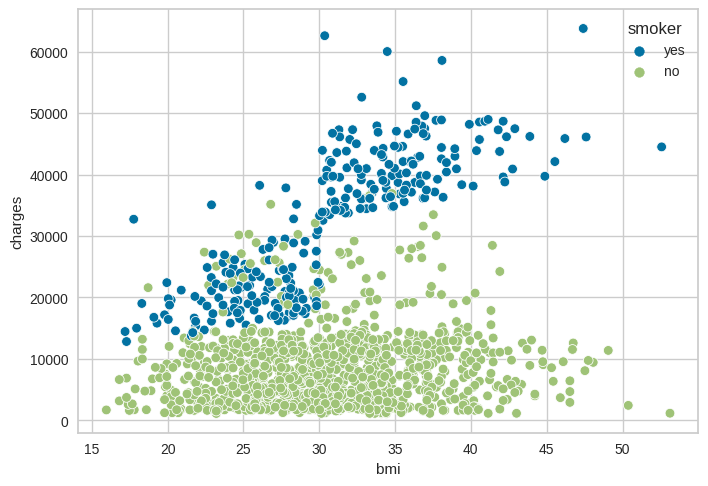

In [9]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

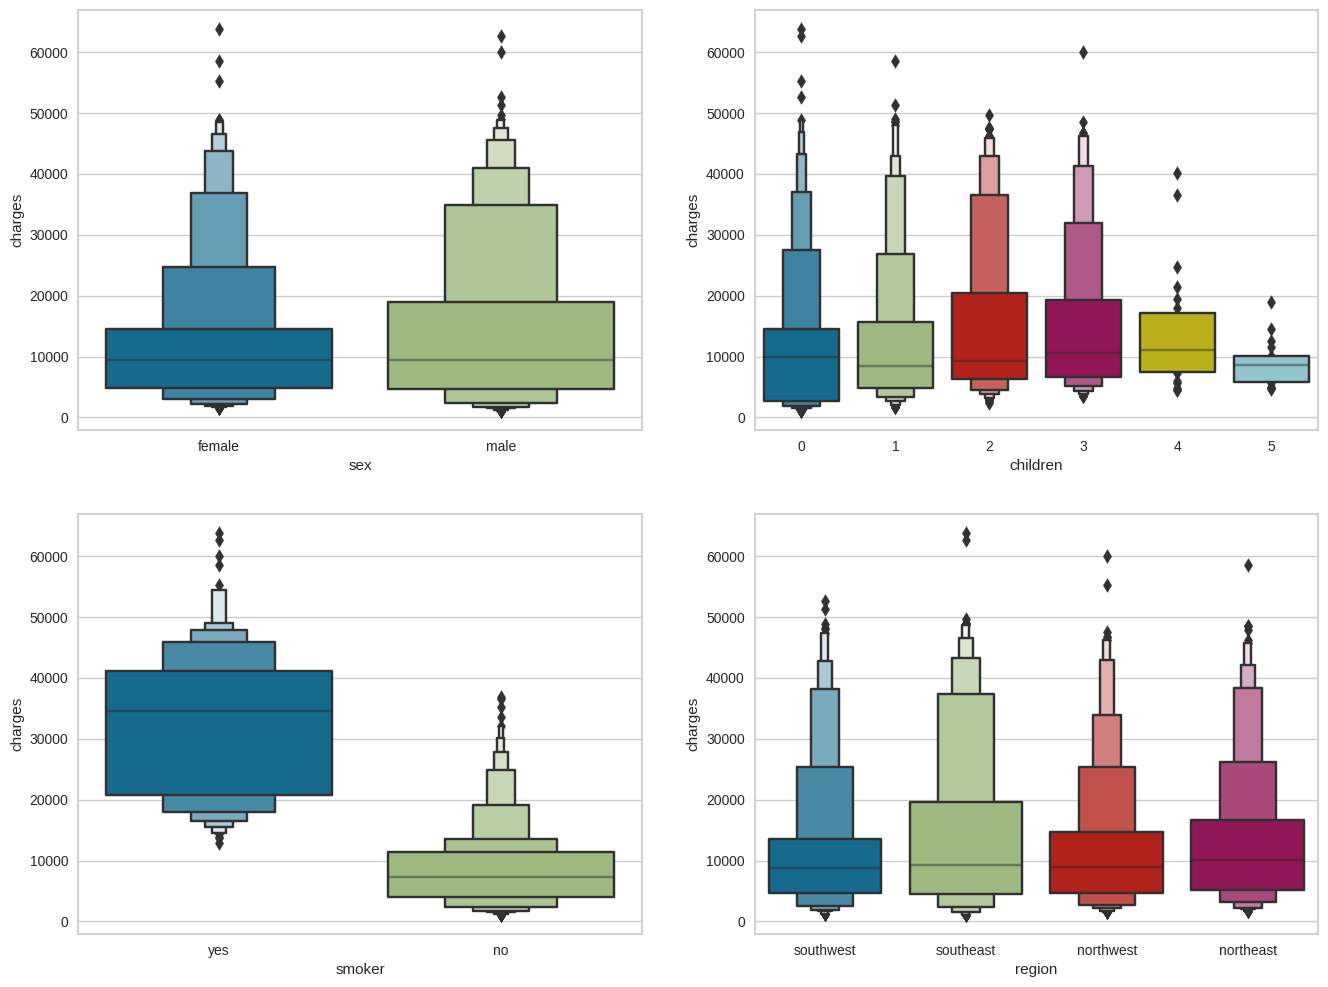

In [10]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f,axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
for col, ax in zip(cat_plot_cols, axes.flatten()):
    sns.boxenplot(x=col, y='charges', data=df, ax=ax)

- calculo da correlação entre as colunas numéricas.

/tmp/ipykernel_11124/686972001.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfc = df.corr()


<Axes: >

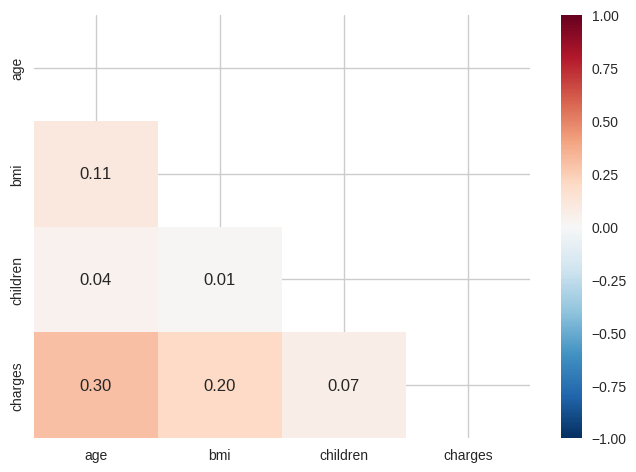

In [11]:
dfc = df.corr()
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask=mask)

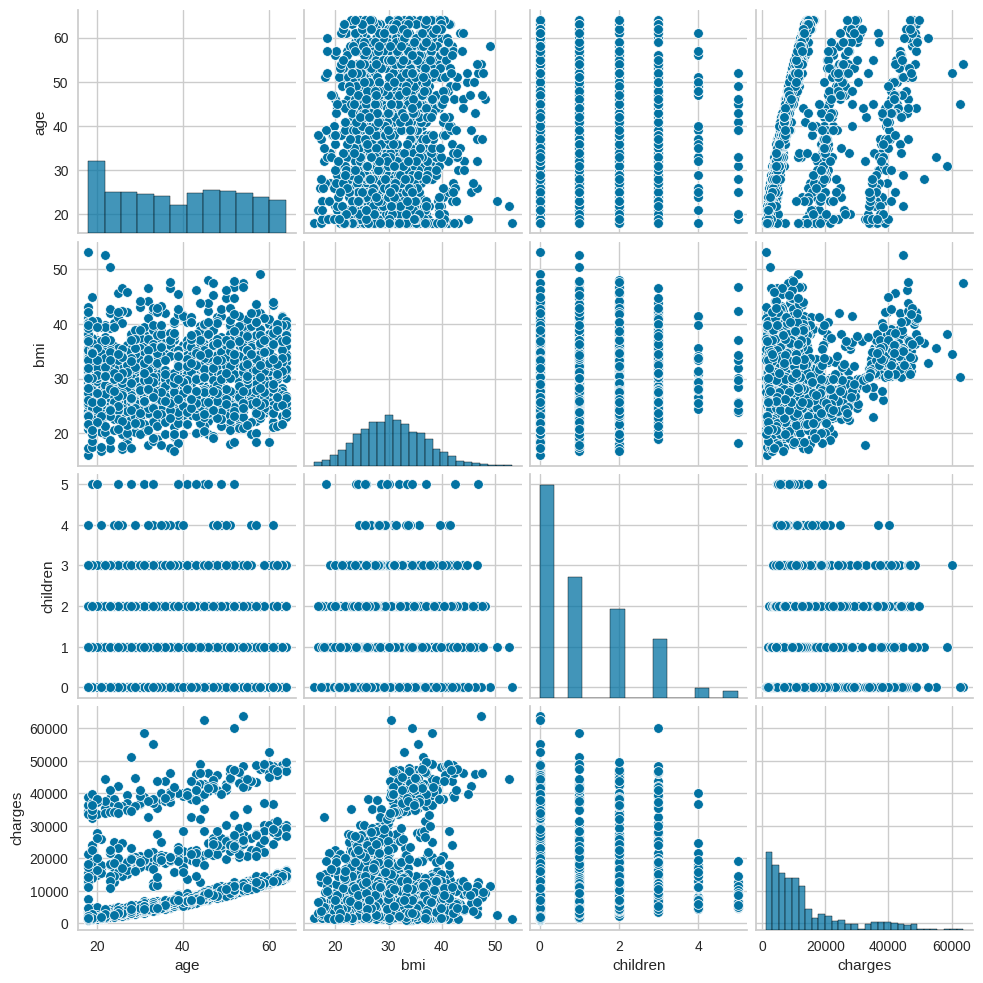

In [12]:
sns.pairplot(df)

# Modelin

In [13]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

In [14]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=2023)

In [15]:
numerical_transfor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transform = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Agora vamos fechar as transformações em um preprocessador

preprocessador = ColumnTransformer([
    ('num', numerical_transfor, NUMERICAL_FEATURES),
    ('cat', categorical_transform, CATEGORICAL_FEATURES)
])

preprocessador.fit_transform(X_train)

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northeast,cat__region_northwest,cat__region_southeast,cat__region_southwest
1068,0.978261,0.153349,0.2,1.0,0.0,0.0,1.0,0.0,0.0
1018,0.782609,0.534167,0.6,0.0,0.0,0.0,1.0,0.0,0.0
995,0.456522,0.196798,0.6,0.0,0.0,1.0,0.0,0.0,0.0
1248,0.000000,0.641916,0.0,0.0,0.0,0.0,0.0,1.0,0.0
549,0.543478,0.813559,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
884,0.152174,0.288808,0.8,1.0,0.0,0.0,1.0,0.0,0.0
515,0.869565,0.531073,0.0,1.0,0.0,0.0,0.0,0.0,1.0
695,0.173913,0.651735,0.0,0.0,0.0,0.0,1.0,0.0,0.0
454,0.304348,0.822437,0.4,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Agora vamos criar a pipeline para o modelo

model_pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', DummyRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', DummyRegressor())])

In [17]:
model_pipeline.named_steps

{'preprocessador': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['age', 'bmi', 'children']),
                                 ('cat',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='ignore',
                                                sparse_output=False),
                                  ['sex', 'smoker', 'region'])]),
 'model': DummyRegressor()}

In [18]:
params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=2023),
        GradientBoostingRegressor(random_state=2023)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessador',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'model': [DummyRegressor(), LinearRegression(),
                                   LassoCV(), RidgeCV(),
                                   RandomForestRegressor(random_state=2023),
                                   GradientBoostingRegressor(random_state=2023)]},
             scoring='r2', verbose=1)

In [19]:
grid_model.best_estimator_

Pipeline(steps=[('preprocessador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=2023))])

In [20]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,
1,GradientBoostingRegressor(random_state=2023),{'model': GradientBoostingRegressor(random_sta...,0.849721,0.006758
2,RandomForestRegressor(random_state=2023),{'model': RandomForestRegressor(random_state=2...,0.840805,0.006099
3,LassoCV(),{'model': LassoCV()},0.743770,0.016151
4,RidgeCV(),{'model': RidgeCV()},0.743745,0.016170
5,LinearRegression(),{'model': LinearRegression()},0.743337,0.016676
6,DummyRegressor(),{'model': DummyRegressor()},-0.001045,0.001007


In [21]:

model_pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', GradientBoostingRegressor(random_state=2023))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1.0, 0.8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessador',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=2023))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

In [22]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858128,0.006150
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857813,0.006408
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857035,0.006536
4,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856641,0.006493
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856395,0.005296
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.855619,0.006343
7,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.853973,0.006299
8,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.853653,0.007385
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.853506,0.005888


In [23]:
model_pipeline = grid_model.best_estimator_

In [24]:
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test, y_pred)

{'R2': 0.8666376387968089,
 'MAE': 2497.122249202784,
 'MAPE': 0.3013239427631112,
 'RMSE': 4190.521276202634}

<Axes: xlabel='charges'>

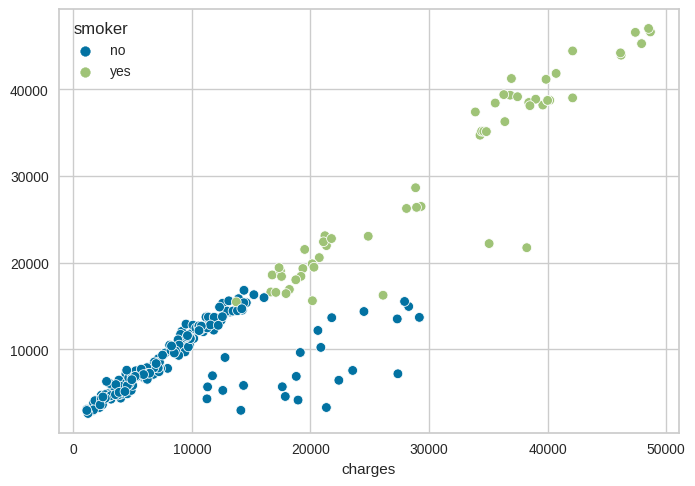

In [26]:
sns.scatterplot(x=y_test, y=y_pred, hue=X_test.smoker)

<Axes: >

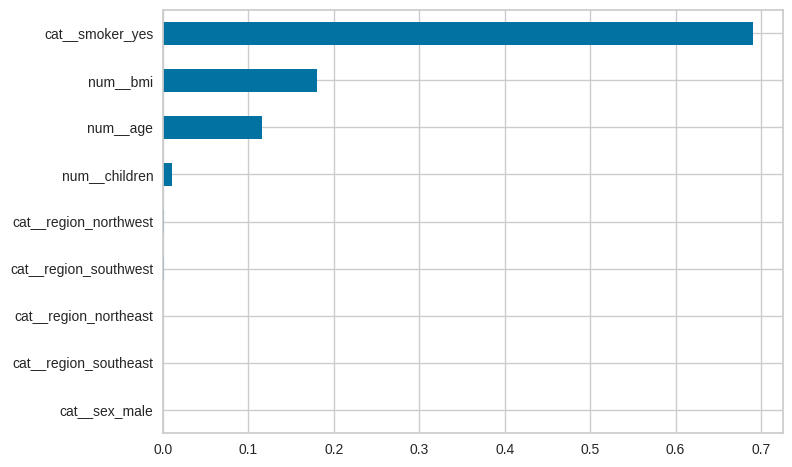

In [32]:
importances = pd.Series(
    model_pipeline.named_steps['model'].feature_importances_,
    model_pipeline.named_steps['preprocessador'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [33]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['smoker']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=2023)

In [35]:
numerical_transfor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transform = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Agora vamos fechar as transformações em um preprocessador

preprocessador = ColumnTransformer([
    ('num', numerical_transfor, NUMERICAL_FEATURES),
    ('cat', categorical_transform, CATEGORICAL_FEATURES)
])

model_pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', GradientBoostingRegressor(random_state=2023))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')].head()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858296,0.005796
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857616,0.005870
3,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857418,0.006570
4,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857355,0.006400
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856735,0.005107


In [36]:
model_pipeline = grid_model.best_estimator_
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test, y_pred)

{'R2': 0.8658322662820985,
 'MAE': 2488.7894076326684,
 'MAPE': 0.29804532488286706,
 'RMSE': 4203.155465756373}

<Axes: >

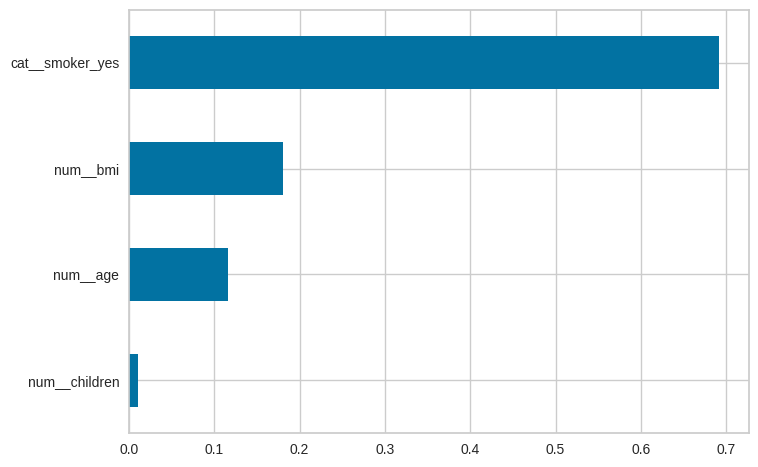

In [37]:
importances = pd.Series(
    model_pipeline.named_steps['model'].feature_importances_,
    model_pipeline.named_steps['preprocessador'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [44]:
with open('/home/faust/Projetos/DNC/Mes-06/insurence/models/model.pkl', 'wb') as file_model:
    pickle.dump(model_pipeline, file_model)